# **Лабораторная работа №5:**
Датасет: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small 

Классификация изображений. В датасете несколько разных классификаций, используйте "subCategory" в качестве рабочей. Задача - обучить обычную CNN и Resnet50 на этом наборе с иллюстрацией процесса обучения для обеих моделей и выводом времени обучения (при равном количестве эпох), а затем обучить те же модели (без запоминания весов, т.е. сначала), но вчетверо уменьшить размеры обучающей выборки (удалить 3/4 картинок из каждого класса). Сделать вывод относительно того, как показывают себя обе модели в условиях меньшего количества обучающих данных.

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import time
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

# **Полный датасет**

## **Подготовка датасета и изображений**

In [ ]:
styles_df = pd.read_csv('/content/myntradataset/styles.csv', error_bad_lines=False)

count_sub_categories = styles_df['subCategory'].value_counts()
valid_sub_categories = count_sub_categories[count_sub_categories >= 4].index # маска для отбора (ругается, если всего 2-3 экземпляра класса, поэтому взял от 4)

styles_df = styles_df[styles_df['subCategory'].isin(valid_sub_categories)]

In [ ]:
train_df, test_df = train_test_split(styles_df, test_size=0.2, random_state=42, stratify=styles_df['subCategory'])
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

def add_image_path(df): # добавляем столбец с путем для картинки
    df['image_path'] = '/content/myntradataset/images/' + df['id'].astype(str) + '.jpg'
    return df

train_df = add_image_path(train_df)
test_df = add_image_path(test_df)


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True) # сдвиг, масштабировние, отброжение погоризонтали, увеличиваем данные для обучения  

test_datagen = ImageDataGenerator(rescale=1./255) 

# применяем генираторы 

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col='image_path',
                                                    y_col='subCategory',
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical') 

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  x_col='image_path',
                                                  y_col='subCategory',
                                                  target_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False)


Found 35531 validated image filenames belonging to 42 classes.
Found 8883 validated image filenames belonging to 42 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


## **CNN для полного датасета**

In [ ]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

cnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [ ]:
start_time = time.time()
cnn_history = cnn_model.fit(train_generator, epochs=10, validation_data=test_generator)
end_time = time.time()

cnn_model.save('cnn_model.h5')

training_time = end_time - start_time

Epoch 1/10
1111/1111 [==============================] - 442s 387ms/step - loss: 1.1894 - accuracy: 0.7005 - val_loss: 0.5688 - val_accuracy: 0.8476
Epoch 2/10
1111/1111 [==============================] - 405s 364ms/step - loss: 0.7068 - accuracy: 0.8144 - val_loss: 0.4301 - val_accuracy: 0.8881
Epoch 3/10
1111/1111 [==============================] - 396s 356ms/step - loss: 0.5749 - accuracy: 0.8469 - val_loss: 0.3642 - val_accuracy: 0.9046
Epoch 4/10
1111/1111 [==============================] - 394s 355ms/step - loss: 0.5043 - accuracy: 0.8654 - val_loss: 0.3292 - val_accuracy: 0.9140
Epoch 5/10
1111/1111 [==============================] - 401s 361ms/step - loss: 0.4620 - accuracy: 0.8747 - val_loss: 0.3070 - val_accuracy: 0.9200
Epoch 6/10
1111/1111 [==============================] - 401s 361ms/step - loss: 0.4167 - accuracy: 0.8847 - val_loss: 0.2904 - val_accuracy: 0.9225
Epoch 7/10
1111/1111 [==============================] - 402s 362ms/step - loss: 0.3844 - accuracy: 0.8936 - val_

In [ ]:
print("Время обучения: " + str(training_time))

Время обучения: 4076.4674978256226


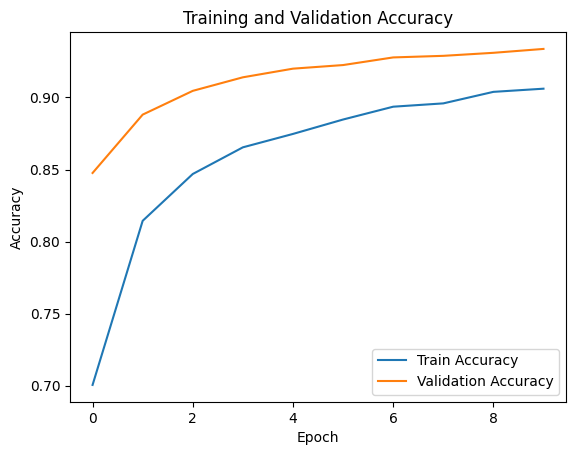

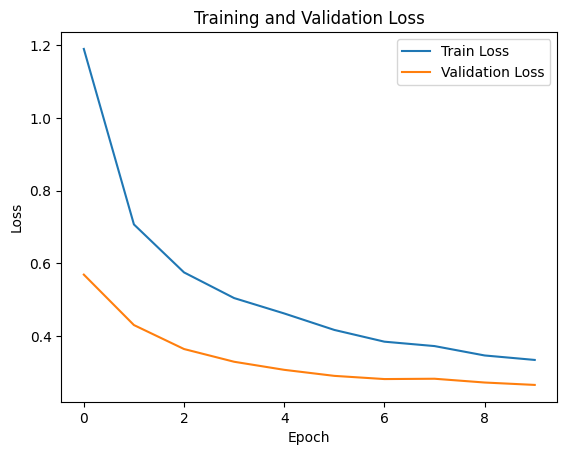

In [ ]:
train_acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']

train_loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **Resnet50 для полного датасета**

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = MaxPooling2D(pool_size=(7, 7))(x) # MaxPooling2D с размером пула (7, 7) уменьшает пространственные размеры (ширину и высоту) до 1, так что получается тензор размером (batch_size, 1, 1, 2048).
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

resnet50_model = Model(inputs=base_model.input, outputs=predictions)

resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [ ]:
start_time = time.time()

resnet50_history = resnet50_model.fit(train_generator, epochs=10, validation_data=test_generator)

end_time = time.time()

resnet50_model.save('resnet50_model.h5')

training_time_renet50 = end_time - start_time

Epoch 1/10
1111/1111 [==============================] - 599s 491ms/step - loss: 1.6064 - accuracy: 0.6526 - val_loss: 2.3857 - val_accuracy: 0.4721
Epoch 2/10
1111/1111 [==============================] - 542s 488ms/step - loss: 0.8714 - accuracy: 0.7841 - val_loss: 1.7544 - val_accuracy: 0.5010
Epoch 3/10
1111/1111 [==============================] - 545s 490ms/step - loss: 0.8140 - accuracy: 0.8027 - val_loss: 6.2251 - val_accuracy: 0.4700
Epoch 4/10
1111/1111 [==============================] - 546s 491ms/step - loss: 0.6841 - accuracy: 0.8283 - val_loss: 1.7605 - val_accuracy: 0.7683
Epoch 5/10
1111/1111 [==============================] - 538s 485ms/step - loss: 0.6633 - accuracy: 0.8309 - val_loss: 8.4959 - val_accuracy: 0.2841
Epoch 6/10
1111/1111 [==============================] - 541s 487ms/step - loss: 0.6706 - accuracy: 0.8278 - val_loss: 0.8131 - val_accuracy: 0.8147
Epoch 7/10
1111/1111 [==============================] - 561s 505ms/step - loss: 0.5756 - accuracy: 0.8473 - val_

In [ ]:
print("Время обучения: " + str(training_time_renet50))

Время обучения: 5568.1316549777985


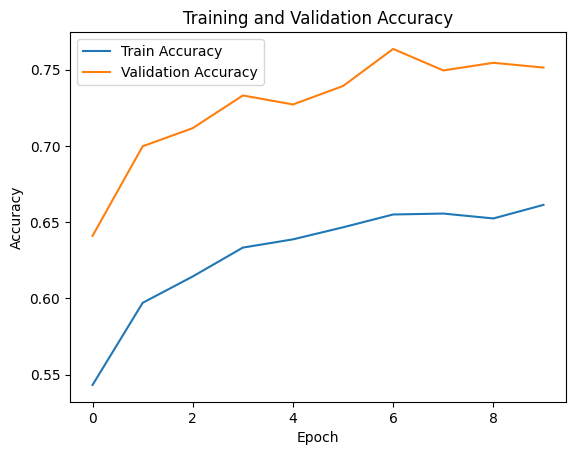

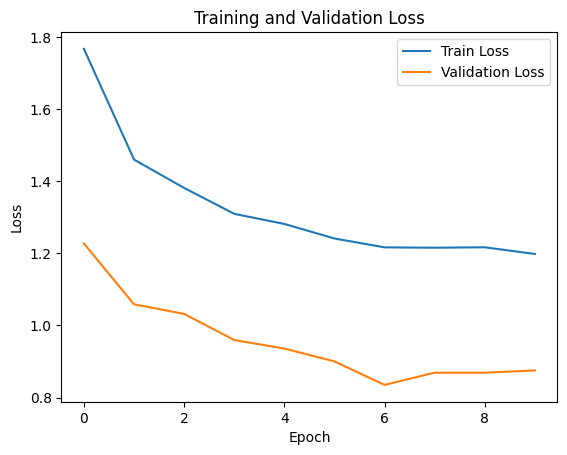

In [ ]:
train_acc = resnet50_history.history['accuracy']
val_acc = resnet50_history.history['val_accuracy']

train_loss = resnet50_history.history['loss']
val_loss = resnet50_history.history['val_loss']

plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **1/4 от обучающей**

## **Подготовка датасета**

In [ ]:
def reduce_dataset(df, factor=4):
    reduced_df = df.groupby('subCategory').apply(lambda x: x.sample(frac=1/factor)).reset_index(drop=True)
    return reduced_df

In [ ]:
reduced_train_df = reduce_dataset(train_df)

reduced_train_generator = train_datagen.flow_from_dataframe(dataframe=reduced_train_df,
                                                            x_col='image_path',
                                                            y_col='subCategory',
                                                            target_size=IMG_SIZE,
                                                            batch_size=BATCH_SIZE,
                                                            class_mode='categorical')

Found 8886 validated image filenames belonging to 42 classes.


## **CNN для 1/4 обучающей**

In [ ]:
cnn_model_reduced = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

cnn_model_reduced.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [ ]:
start_time = time.time()
cnn_history_reduced = cnn_model_reduced.fit(reduced_train_generator, epochs=10, validation_data=test_generator)
end_time = time.time()

cnn_model_reduced.save('cnn_model_reduced.h5')

training_time_cnn_model_reduced = end_time - start_time

Epoch 1/10
278/278 [==============================] - 111s 394ms/step - loss: 1.8351 - accuracy: 0.5639 - val_loss: 0.9477 - val_accuracy: 0.7580
Epoch 2/10
278/278 [==============================] - 116s 418ms/step - loss: 1.1320 - accuracy: 0.7115 - val_loss: 0.7169 - val_accuracy: 0.8079
Epoch 3/10
278/278 [==============================] - 108s 388ms/step - loss: 0.9362 - accuracy: 0.7549 - val_loss: 0.6821 - val_accuracy: 0.8195
Epoch 4/10
278/278 [==============================] - 107s 387ms/step - loss: 0.8313 - accuracy: 0.7770 - val_loss: 0.5577 - val_accuracy: 0.8494
Epoch 5/10
278/278 [==============================] - 110s 396ms/step - loss: 0.7702 - accuracy: 0.7930 - val_loss: 0.4932 - val_accuracy: 0.8687
Epoch 6/10
278/278 [==============================] - 117s 420ms/step - loss: 0.7112 - accuracy: 0.8060 - val_loss: 0.5069 - val_accuracy: 0.8711
Epoch 7/10
278/278 [==============================] - 111s 401ms/step - loss: 0.6759 - accuracy: 0.8167 - val_loss: 0.4480 -

In [ ]:
print("Время обучения: " + str(training_time_cnn_model_reduced))

Время обучения: 1271.6597623825073


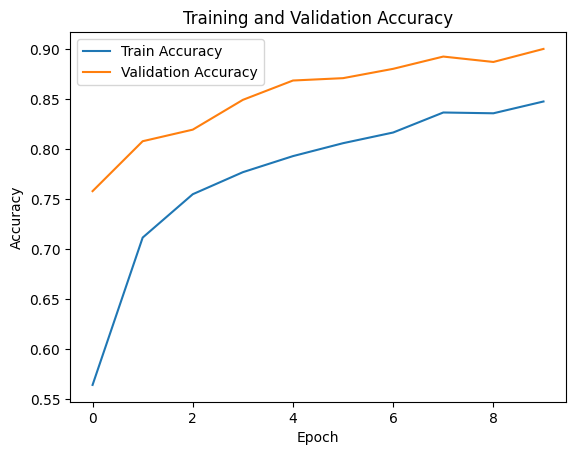

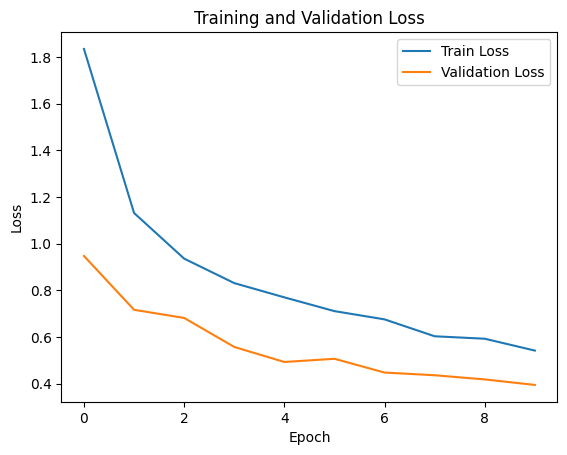

In [ ]:
train_acc = cnn_history_reduced.history['accuracy']
val_acc = cnn_history_reduced.history['val_accuracy']

train_loss = cnn_history_reduced.history['loss']
val_loss = cnn_history_reduced.history['val_loss']

plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **Resnet50 для 1/4 обучающей**

In [ ]:
base_model_reduced = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model_reduced.output
x = MaxPooling2D(pool_size=(7, 7))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

resnet50_model_reduced = Model(inputs=base_model_reduced.input, outputs=predictions)

resnet50_model_reduced.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [ ]:
start_time = time.time()

resnet50_history_reduced = resnet50_model_reduced.fit(reduced_train_generator, epochs=10, validation_data=test_generator)

end_time = time.time()


training_time_resnet50_reduced = end_time - start_time

Epoch 1/10
278/278 [==============================] - 200s 579ms/step - loss: 2.1890 - accuracy: 0.6494 - val_loss: 3.2016 - val_accuracy: 0.0408
Epoch 2/10
278/278 [==============================] - 174s 625ms/step - loss: 0.8388 - accuracy: 0.7896 - val_loss: 3.1314 - val_accuracy: 0.0458
Epoch 3/10
278/278 [==============================] - 161s 580ms/step - loss: 0.7218 - accuracy: 0.8252 - val_loss: 2.3116 - val_accuracy: 0.4067
Epoch 4/10
278/278 [==============================] - 160s 576ms/step - loss: 0.5888 - accuracy: 0.8479 - val_loss: 0.5244 - val_accuracy: 0.8556
Epoch 5/10
278/278 [==============================] - 171s 616ms/step - loss: 0.5020 - accuracy: 0.8704 - val_loss: 0.5205 - val_accuracy: 0.8651
Epoch 6/10
278/278 [==============================] - 159s 570ms/step - loss: 0.4714 - accuracy: 0.8749 - val_loss: 1.2612 - val_accuracy: 0.7174
Epoch 7/10
278/278 [==============================] - 171s 615ms/step - loss: 0.4583 - accuracy: 0.8821 - val_loss: 0.4635 -

In [ ]:
resnet50_model_reduced.save('resnet50_model_reduced.h5')

In [ ]:
training_time_resnet50_reduced = end_time - start_time
print("Время обучения: " + str(training_time_resnet50_reduced))

Время обучения: 1343.875607252121


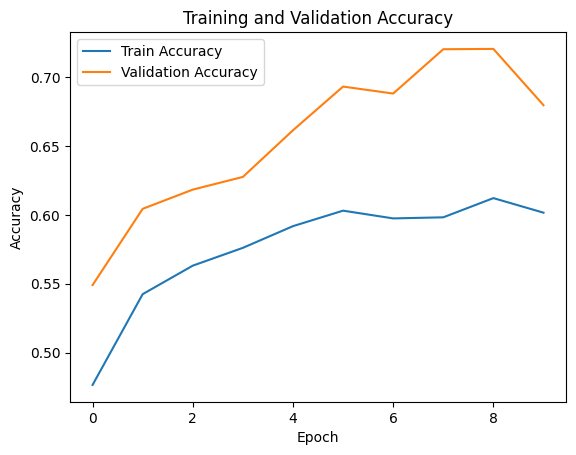

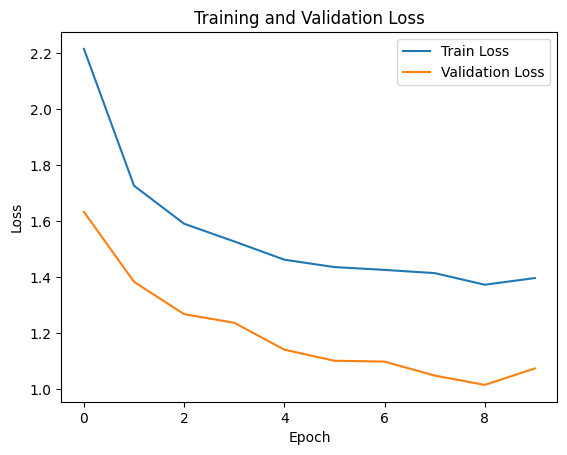

In [ ]:
train_acc = resnet50_history_reduced.history['accuracy']
val_acc = resnet50_history_reduced.history['val_accuracy']

train_loss = resnet50_history_reduced.history['loss']
val_loss = resnet50_history_reduced.history['val_loss']

plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc

# **ВЫВОД**

В ходе данной работы мы обучили две модели классификации изображений - обычную сверточную нейронную сеть (CNN) и ResNet50 - на полном и сокращенном наборе данных. Основываясь на полученных результатах, можно сделать следующие выводы:

Обе модели не показывают признаков переобучения, что указывает на то, что они успешно обобщают информацию из обучающей выборки и могут быть использованы для предсказания на новых данных.

Для более короткой тренировочной выборки обычная CNN показала себя хуже по сравнению с полным набором данных. Вероятно, это связано с тем, что обычная CNN требует больше данных для обучения, чтобы достичь высокой точности.

ResNet50, напротив, обучается лучше на короткой выборке данных. Это может быть связано с тем, что ResNet50 предварительно обучен на большом наборе данных ImageNet, и в связи с этим он может обобщать информацию лучше, даже когда доступно меньше обучающих данных.

В целом, обычная CNN показывает себя немного лучше, чем ResNet50, что может быть связано с тем, что она лучше подходит для данной задачи классификации или имеет более подходящую архитектуру для данного набора данных.

Таким образом, можно заключить, что выбор оптимальной модели для задачи классификации изображений во многом зависит от доступного количества данных и специфики задачи. В данном случае, обычная CNN показала себя лучше, однако ResNet50 также продемонстрировал хорошие результаты, особенно при меньшем количестве обучающих данных.